In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1.7. Finding concepts in texts - Latent Dirichlet Allocation

Latent Semantic Analysis provided a powerful way to begin interrogating relationships among texts.

In this notebook we use the [gensim implementation](https://radimrehurek.com/gensim/wiki.html#latent-dirichlet-allocation) of Online LDA ([Hoffman et al 2010](https://www.cs.princeton.edu/~blei/papers/HoffmanBleiBach2010b.pdf)), which is an alternate of the typical Gibbs-Sampling MCMC approach.

In [46]:
import nltk
from tethne.readers import zotero
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import gensim
import networkx as nx
import pandas as pd

from collections import defaultdict, Counter

wordnet = nltk.WordNetLemmatizer()
stemmer = nltk.SnowballStemmer('english')
stoplist = stopwords.words('english')


In [5]:
text_root = '../data/EmbryoProjectTexts/files'
zotero_export_path = '../data/EmbryoProjectTexts'

corpus = nltk.corpus.PlaintextCorpusReader(text_root, 'https.+')
metadata = zotero.read(zotero_export_path, index_by='link', follow_links=False)

In [26]:
def normalize_token(token):
    """
    Convert token to lowercase, and stem using the Porter algorithm.

    Parameters
    ----------
    token : str

    Returns
    -------
    token : str
    """
    return wordnet.lemmatize(token.lower())

def filter_token(token):
    """
    Evaluate whether or not to retain ``token``.

    Parameters
    ----------
    token : str

    Returns
    -------
    keep : bool
    """
    token = token.lower()
    return token not in stoplist and token.isalpha() and len(token) > 2

We will represent our documents as a list of lists. Each sub-list contains tokens in the document.

In [27]:
documents=[[normalize_token(token) 
            for token in corpus.words(fileids=[fileid])
            if filter_token(token)]
           for fileid in corpus.fileids()]

In [37]:
years = [metadata[fileid].date for fileid in corpus.fileids()]

## Further filtering

LDA in Python is a bit computationally expensive, so anything we can do to cut down on "noise" will help. Let's take a look at wordcounts and documentcounts to see whether we can narrow in on more useful terms.

In [28]:
wordcounts = nltk.FreqDist([token for document in documents for token in document])

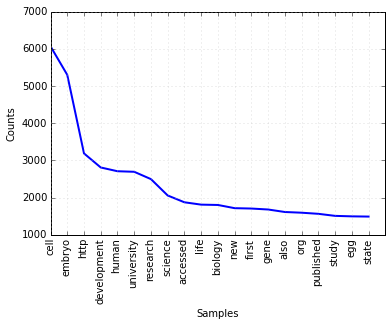

In [29]:
wordcounts.plot(20)

In [30]:
documentcounts = nltk.FreqDist([token for document in documents for token in set(document)])

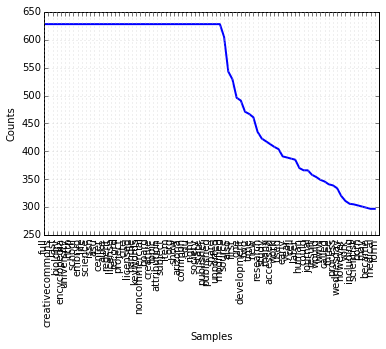

In [31]:
documentcounts.plot(80)

Here we filter the tokens in each document, preserving the shape of the corpus.

In [32]:
filtered_documents = [[token for token in document 
                      if wordcounts[token] < 2000
                      and 1 < documentcounts[token] < 350]
                     for document in documents]

It's easier to compute over integers, so we use a ``Dictionary`` to create a mapping between words and their integer/id representation.

In [33]:
dictionary = gensim.corpora.Dictionary(filtered_documents)

The ``doc2bow()`` converts a document (series of tokens) into a bag-of-words representation.

In [34]:
documents_bow = [dictionary.doc2bow(document) for document in filtered_documents]

We're ready to fit the model! We pass our BOW-transformed documents, our dictionary, and the number of topics. ``update_every=0`` disables an "online" feature in the sampler (used for very very large corpora), and ``passes=20`` tells the sampler to pass over the whole corpus 20 times.

In [35]:
model = gensim.models.LdaModel(documents_bow, 
                               id2word=dictionary,
                               num_topics=20, 
                               update_every=0,
                               passes=20)

In [41]:
for i, topic in enumerate(model.print_topics(num_topics=20, num_words=5)):
    print i, ':', topic

0 : 0.012*dna + 0.010*genome + 0.008*www + 0.006*eugenics + 0.006*gene
1 : 0.012*fetus + 0.012*woman + 0.011*case + 0.011*court + 0.009*fetal
2 : 0.013*alcohol + 0.012*child + 0.010*defect + 0.009*egg + 0.009*autism
3 : 0.024*stem + 0.020*plant + 0.016*pluripotent + 0.013*genetic + 0.011*seed
4 : 0.015*stem + 0.009*bioethics + 0.008*egg + 0.008*president + 0.007*cloning
5 : 0.013*birth + 0.013*death + 0.009*blood + 0.009*pill + 0.008*hartman
6 : 0.023*sex + 0.015*male + 0.011*female + 0.010*hormone + 0.009*lillie
7 : 0.010*fistula + 0.009*spemann + 0.008*organizer + 0.006*hamlin + 0.006*experiment
8 : 0.011*theory + 0.008*animal + 0.006*organism + 0.006*evolution + 0.006*specie
9 : 0.008*loeb + 0.007*organism + 0.006*theory + 0.006*egg + 0.006*embryology
10 : 0.018*theory + 0.017*weismann + 0.010*germ + 0.010*darwin + 0.009*heredity
11 : 0.023*gene + 0.009*protein + 0.007*mouse + 0.007*nucleus + 0.006*experiment
12 : 0.018*cocaine + 0.010*stage + 0.008*blood + 0.008*sandel + 0.008*gene

In [42]:
documents_lda = model[documents_bow]

In [43]:
documents_lda[6]

[(12, 0.014435555062542226),
 (14, 0.085751791682966233),
 (15, 0.16342467897748753),
 (16, 0.73486706170519944)]

In [44]:
topic_counts = defaultdict(Counter)
for year, document in zip(years, documents_lda):
    for topic, representation in document:
        topic_counts[topic][year] += 1.

In [47]:
topics_over_time = pd.DataFrame(columns=['Topic', 'Year', 'Count'])

i = 0
for topic, yearcounts in topic_counts.iteritems():
    for year, count in yearcounts.iteritems():
        topics_over_time.loc[i] = [topic, year, count]
        i += 1

In [48]:
topics_over_time

,Topic,Year,Count
0,0,2016,1
1,0,2007,18
2,0,2008,3
3,0,2009,7
4,0,2010,22
5,0,2011,19
6,0,2012,8
7,0,2013,13
8,0,2014,39
9,0,2015,8


In [58]:
topic_0_over_time = topics_over_time[topics_over_time.Topic == 0]

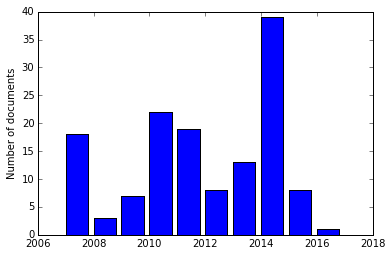

In [60]:
plt.bar(topic_0_over_time.Year, topic_0_over_time.Count)
plt.ylabel('Number of documents')
plt.show()

In [63]:
from scipy.spatial import distance

In [64]:
distance.cosine

<function scipy.spatial.distance.cosine>